# <center> Topic 3. Statistical Learning with Scikit-Learn

Сегодня вам предстоит на практике познакомиться с основными задачами машинного обучения.
В ходе работы получится поработать с популярными библиотеками [`pandas`](https://pandas.pydata.org/), [`numpy`](https://numpy.org/), [`sklearn`](https://scikit-learn.org/stable/).

Для выполнения задания необходимо следовать по этой тетрадке сверху вниз и заполнять недостающее части кода или отвечать на заданные вопросы.

In [ ]:
# Импортируем необходимые библиотеки
# Полезно все импорты держать рядом

from os.path import exists

import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from PIL import Image
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.utils import shuffle
%matplotlib inline

In [ ]:
# Зафиксируем сид для генератора случайных чисел
# Это полезно для воспроизводимости результатов

RANDOM_SEED = 0xC0FFEE

# Классификация

Для знакомства с задачей классификацией воспользуемся выборкой данных о пациентах с доброкачественными и злокачественными опухолями. Наша задача — научиться их отличать.

Вместе с тетрадкой находится файл `cancer.csv` — это таблица, где каждая строчка соответствует отдельной клетке, а столбцы ее численные характеристики. Подробнее про датасет можно прочитать, например, вот [тут](
https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data).

Начнем с чтения данных с диска, для этого реализуйте функцию `read_cancer_dataset`.
Поможет с этим библиотека `pandas` и пара полезных вещей из нее:
1. [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)
2. [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)

In [ ]:
def read_cancer_dataset(path_to_csv: str, shuffle: bool = True) -> pd.DataFrame:
    """Функция для чтения данных с диска, а также их случайного перемешивания

    Parameters
    ----------
    path_to_csv: Путь к файлу cancer.csv
    shuffle: Если True, то перемешивает данные

    Return
    ------
    dataframe: Данные в формате DataFrame
    """
    df = pd.read_csv(path_to_csv)
    if shuffle:
        indexes = np.linspace(0, df.shape[0]-1, df.shape[0])
        np.random.shuffle(indexes)
        df = df.iloc[indexes]
    return df
    # df = sklearn.utils.shuffle(pd.read_csv(path_to_csv)) if shuffle else pd.read_csv(path_to_csv)


In [ ]:
# Посмотрим на наши данные:
# Колонка "label" отвечает за тип опухоли
# Колонки 1-30 отвечают за признаки

cancer_dataset = read_cancer_dataset("cancer.csv", shuffle=True)
cancer_dataset.head()

,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
282,M,19.400,18.18,127.20,1145.0,0.10370,0.14420,0.16260,0.09464,0.1893,...,23.79,28.65,152.40,1628.0,0.1518,0.3749,0.43160,0.2252,0.3590,0.07787
329,M,16.260,21.88,107.50,826.8,0.11650,0.12830,0.17990,0.07981,0.1869,...,17.73,25.21,113.70,975.2,0.1426,0.2116,0.33440,0.1047,0.2736,0.07953
416,B,9.405,21.70,59.60,271.2,0.10440,0.06159,0.02047,0.01257,0.2025,...,10.85,31.24,68.73,359.4,0.1526,0.1193,0.06141,0.0377,0.2872,0.08304
291,B,14.960,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,...,16.25,26.19,109.10,809.8,0.1313,0.3030,0.18040,0.1489,0.2962,0.08472
210,M,20.580,22.14,134.70,1290.0,0.09090,0.13480,0.16400,0.09561,0.1765,...,23.24,27.84,158.30,1656.0,0.1178,0.2920,0.38610,0.1920,0.2909,0.05865


Первым делом необходимо подготовить данные к работе, а именно: разбить на тренировочную и тестовую части.

<u>Тренировочная часть</u> используется для обучения моделей, именно по ней ищутся необходимые зависимости в данных.

<u>Тестовая часть</u> используется для оценки качества моделей. Это данные, которые модель не видела, поэтому качество предсказаний по ним позволит оценить ее обобщающие способности.

Крайне важно, чтобы тестовая и тренировочная части описывали одинаковую природу данных. Например, в случае задачи классификации, важно чтобы соотношение классов было приблизительно равно в них. Иначе мы можем неправильно интерпретировать результаты.

Реализуйте функцию `prepare_cancer_dataset`, которая разделяет данные на таргет и признаки, а также выделяет тестовую часть. В этом может помочь [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) из библиотеки `sklearn`. Не забывайте фиксировать `random_state` или другие аналогичные параметры — это полезная привычка, которая съэкономить вам сотни часов дебага в будущем.

In [ ]:
df_ = pd.read_csv("cancer.csv")
df_['label']

,label
0,M
1,M
2,M
3,M
4,M
...,...
564,M
565,M
566,M
567,M


In [ ]:
def prepare_cancer_dataset(
    dataset: pd.DataFrame, label_col_name: str = "label", test_size: float = 0.1
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Функция для выделения таргета и признаков,
    а также разделения на тренировочную и тестовую части.

    Для таргета необходимо привести данные к формату 0/1.
    Сопоставьте 0 доброкачественной опухоли ("B"),
    а 1 злокачественной ("M")

    Parameters
    ----------
    dataset: DataFrame с датасетом
    label_col_name: Название колонки с таргетом
    test_size: доля тестовой выборки относительно всего датасета

    Return
    ------
        4 numpy массива: X_train, X_test, y_train, y_test
        X_train, X_test -- матрицы признаков размером [n_elements; 30]
        y_train, y_test -- массивы из 0 и 1 размером [n elements]
    """
    X = dataset.drop('label', axis=1)
    y = dataset['label']
    y = y.replace(['B', 'M'], [0, 1])
    return train_test_split(X, y, test_size=test_size, random_state=RANDOM_SEED, stratify=y)

In [ ]:
# Выполним подготовку данных
X_train, X_test, y_train, y_test = prepare_cancer_dataset(cancer_dataset)

# Код ниже проверяет правильность подготовки данных
# Если он упал, то надо исправить функцию выше
assert X_train.shape == (512, 30) and y_train.shape == (512,)
assert X_test.shape == (57, 30) and y_test.shape == (57,)

train_ratio = y_train.sum() / len(y_train)
test_ratio = y_test.sum() / len(y_test)
assert train_ratio < 0.5
assert np.abs((test_ratio - train_ratio) / train_ratio) < 0.015

<ipython-input-31-3be4c4750d86>:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(['B', 'M'], [0, 1])


Начнем с наивного решения — модель, которая предсказывает наиболее популярный класс.
Реализуйте методы `fit` и `predict` у класса ниже.

In [ ]:
class MostCommonClassifier:
    def __init__(self):
        self.predict_class = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        """Функция обучения наивной модели.
        Она получает на вход X и y,
        чтобы иметь схожий интерфейс с другими моделями.

        Функция определяет самый популярный класс и
        сохраняет его в predict_class

        Parameters
        ----------
        X: признаки, не используются
        y: таргет, номера классов, одномерный массив
        """
        one_count = (y == 1).sum()
        zero_count = ((y == 0) + 1).sum()
        self.predict_class = 1 if one_count > zero_count else 0

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Функция для предсказания классов

        Parameters
        ----------
        X: элементы, для которых надо предсказать класс
            матрица размером [n_elements; n_features]

        Return
        ------
            предсказанный класс для каждого элемента
            numpy массив размером [n_elements]
        """
        if self.predict_class is None:
            raise RuntimeError("Call fit before predict")

        return np.full(shape = X.shape[0], fill_value=self.predict_class)

"Обучим" наивную модель и оценим ее качество.

Для оценки качества воспользуемся двумя популярными метриками:
1. Точность (accuracy) измеряет, как часто модель предсказывает правильные ответы из всех возможных ответов. Она вычисляется как отношение числа правильных предсказаний к общему числу предсказаний. Например, если модель правильно предсказала 80 из 100 объектов, то точность будет равна 0.8 или 80%.

2. F1-score — более сложная метрика, она измеряет сбалансированность модели, учитывая как точность (precision), так и полноту (recall) предсказаний. Точнее говоря, она считает их гармоническое среднее. Использование такой метрики позволяет более точно оценить модели в случае сильной несбалансированности в данных.

Более подробно ознакомиться с метриками классификации можно, например, [тут](https://vk.com/@itresume-sobaka-ili-koshka-razbor-precision-recall-i-f1-score-i-drug).

In [ ]:
def print_classification_report(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%", f"F1-score: {f1 * 100:.2f}%", sep="\n")

In [ ]:
model_most_common = MostCommonClassifier()
model_most_common.fit(X_train, y_train)
y_pred_most_common = model_most_common.predict(X_test)
print_classification_report(y_test, y_pred_most_common)

Accuracy: 63.16%
F1-score: 0.00%


Один из самых простых алгоритмов классификации —  это "K ближайших соседей".
В нем для каждого объекта находятся k наиболее близких объектов и выбирается самый частотный класс среди них.
Давайте воспользуемся им для решения нашей задачи.
Поможет в этом реализация из `sklearn`: [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [ ]:
model_v1 = KNeighborsClassifier(n_jobs=-1)
model_v1.fit(X_train, y_train)
y_pred_v1 = model_v1.predict(X_test)

print_classification_report(y_test, y_pred_v1)

Accuracy: 96.49%
F1-score: 95.24%


Результат уже стал значительно выше! Если вы все сделали верно, то уже должны получить точность выше 90%.

Однако еще есть куда расти.
Один из главных способов поднять качество — это правильно настроить модель.

Ознакомьтесь с документацией алгоритма по ссылке выше и поиграйтесь с параметрами модели.
Например, вместо стандартного `n_neighbors=5` можно поставить `n_neighbors=7`.
Тогда при предсказании класса модель будет смотреть не на 5 ближайших соседей, а на 7.

Попробуйте получить как можно более высокое качество!

In [ ]:
model_v2 = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
model_v2.fit(X_train, y_train)
y_pred_v2 = model_v2.predict(X_test)

print_classification_report(y_test, y_pred_v2)

Accuracy: 96.49%
F1-score: 95.24%


Одна из особенностей алгоритма "K ближайших соседей" — это необходимость вычислять расстояние между векторами признаков. По умолчанию используется обычное евклидово расстояние:

$$
\text{dist}(p, q) = \sqrt{\sum_{i=1}^n (p_i^2 - q_i^2)}
$$

Здесь $p$ и $q$ — это вектора размерности $n$, то есть массивы, описывающие $n$ признаков.

Из формулы можно заменить, что если значения одного из признаков очень большие, то он будет подавлять вклад признаков с маленькими значениями.

Давайте посмотрим на средние значения каждого признака в нашем датасете.

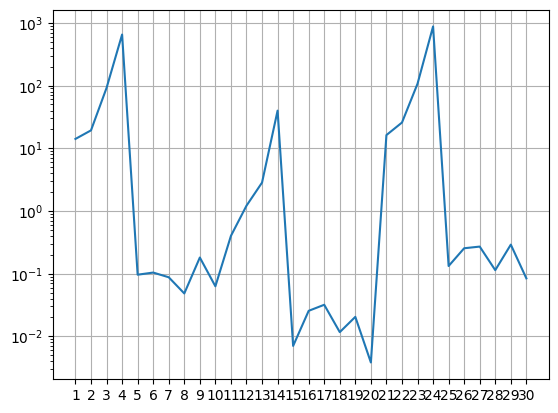

In [ ]:
pyplot.grid(visible=True)
pyplot.yscale("log")
pyplot.plot(X_train.mean(axis=0))
pyplot.show()

Можно заметить, что некоторые признаки в среднем варьируются возле 1000, тогда как другие меньше 0.01.

Чтобы это исправить можно отмасштабировать признаки, а именно привести каждый признак к среднему 0 и дисперсии 1.
Помочь в этом может [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) из библиотеки `sklearn`.

Изучите документацию этого алгоритма и реализуйте функцию `scale_features`.

In [ ]:
def scale_features(
    train_data: np.ndarray, test_data: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Функция для масштабирования данных
    Переводит каждый столбец данных в новый со средним 0 и дисперсией 1.

    Для подсчета статистики и обучения используется тренировочная часть.
    Затем масштабирование применяется и к тестовым данным.

    Parameters
        ----------
        train_data: матрица размером [train_size; n_features]
            Тренировочная часть
        test_data: матрица размером [test_size; n_features]
            Тестовая часть

        Return
        ------
            train_data_scaled, test_data_scaled
                numpy матрицы с отмасштабированными данными
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [ ]:
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

mean, std = X_train_scaled.mean(axis=0), X_train_scaled.std(axis=0)
assert np.allclose(mean, 0) and np.allclose(std, 1)

Обучите `KNeighborsClassifier` на новых данных, не забудьте подобрать оптимальные гиперпараметры.
Возможно достить точности выше 95%!

In [ ]:
model_v3 = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
model_v3.fit(X_train_scaled, y_train)
y_pred_v3 = model_v3.predict(X_test_scaled)

print_classification_report(y_test, y_pred_v3)

Accuracy: 100.00%
F1-score: 100.00%


Задачу классификации можно решать множеством разных способов, многие из которых реализованы в библиотеки `sklearn`.

Вы можете ознакомиться со всем списком алгоритмов в библиотеке [здесь](https://scikit-learn.org/stable/supervised_learning.html). Не все они подходят для задачи классификации, ориентируйтесь на слово `Classifier` в названии, а также не стесняйтесь переходить по ссылкам и читать документацию и описание.

Попробуйте применить новые алгоритмы к нашей задаче. Рекомендуем обратить внимание на:
1. [`LogisticRegression`](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
2. [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles)
3. [`SVC`](https://scikit-learn.org/stable/modules/svm.html#classification)

Для методов на основе линейных преобразований полезно использовать отмасштабированные данные.

Вполне реально получить идеальное качество в 100%!

# Регрессия

Для знакомства с задачей регрессии, нам поможет популярный датасет [Boston](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html), он прикреплен к заданию в файле `boston.csv`.
Это набор данных с информаций о медианной стоимости домов, а также различных характеристик района.
Ознакомиться с датасетом можно по ссылке выше, а ниже представленно описание каждого столбца в данных:
```
1. crim      per capita crime rate by town
2. zn        proportion of residential land zoned for lots over 25,000 sq.ft.
3. indus     proportion of non-retail business acres per town
4. chas      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. nox       nitric oxides concentration (parts per 10 million)
6. rm        average number of rooms per dwelling
7. age       proportion of owner-occupied units built prior to 1940
8. dis       weighted distances to five Boston employment centres
9. rad       index of accessibility to radial highways
10. tax      full-value property-tax rate per \$10,000
11. ptratio  pupil-teacher ratio by town
12. b        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. lstat    % lower status of the population
14. medv     median value of owner-occupied homes in \$'s
```

Наша задача — научится предсказывать стоимость дома по критериям района. То есть вместо ограниченного числа значений, модель теперь должна предсказывать любые целые числа.

Начнем с функции `read_boston_dataset`, которая считывает датасет с диска. В данных первые 14 строчек не относятся к данным, а описывают колонки, для их пропуска полезно использовать `skiprows` в функции `read_csv`.

In [ ]:
def read_boston_dataset(path_to_csv: str, shuffle: bool = True) -> np.ndarray:
    """Функция для чтения данных с диска, а также их случайного перемешивания

    Parameters
    ----------
    path_to_csv: Путь к файлу boston.csv
    shuffle: Если True, то перемешивает данные

    Return
    ------
    dataframe: Данные в формате DataFrame
    """
    df = pd.read_csv(path_to_csv, skiprows=14)
    if shuffle:
        indexes = np.linspace(0, df.shape[0]-1, df.shape[0])
        np.random.shuffle(indexes)
        df = df.iloc[indexes]
    return df

In [ ]:
boston_dataset = read_boston_dataset("boston.csv")
boston_dataset.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
491,0.10574,0.0,27.74,0,0.609,5.983,98.8,1.8681,4,711.0,20.1,390.11,18.07,13600.0
225,0.52693,0.0,6.20,0,0.504,8.725,83.0,2.8944,8,307.0,17.4,382.00,4.63,50000.0
477,15.02340,0.0,18.10,0,0.614,5.304,97.3,2.1007,24,666.0,20.2,349.48,24.91,12000.0
227,0.41238,0.0,6.20,0,0.504,7.163,79.9,3.2157,8,307.0,17.4,372.08,6.36,31600.0
212,0.21719,0.0,10.59,1,0.489,5.807,53.8,3.6526,4,277.0,18.6,390.94,16.03,22400.0


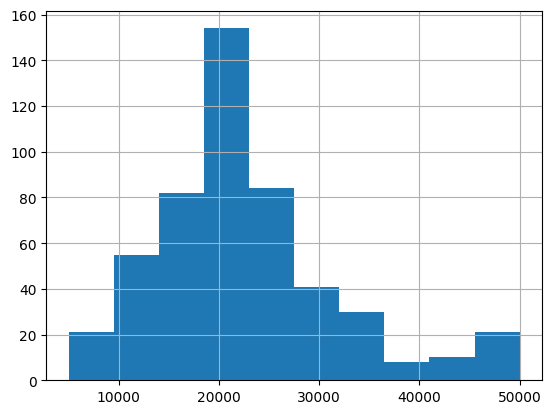

In [ ]:
# Посмотрим на данные чуть ближе
# Оценим распределение цен в датасете

pyplot.hist(boston_dataset["medv"])
pyplot.grid(visible=True)
pyplot.show()

**Вопрос:** сделайте 2-3 вывода относительно цен.

1. Возможно цены нормально распеределены
2. дорогих цен мал
3. большинство цен средние

По аналогии с задачей классификацией, необходимо выделить тренировочную и тестовую выборку.
Реализуйте для этого функцию `prepare_boston_dataset`

In [ ]:
def prepare_boston_dataset(
    dataset: pd.DataFrame, label_col_name: str = "medv", test_size: float = 0.1
) -> tuple[np.ndarray, ...]:
    """Функция для выделения таргета и признаков,
    а также разделения на тренировочную и тестовую части.

    Parameters
    ----------
    dataset: DataFrame с датасетом
    label_col_name: Название колонки с таргетом
    test_size: доля тестовой выборки относительно всего датасета

    Return
    ------
        4 numpy массива: X_train, X_test, y_train, y_test
        X_train, X_test -- матрицы признаков размером [n_elements; 13]
        y_train, y_test -- массивы с ценами размером [n elements]
    """
    X = dataset.drop(label_col_name, axis=1)
    y = dataset[label_col_name]
    return train_test_split(X, y, test_size=test_size, random_state=RANDOM_SEED)

In [ ]:
X_train, X_test, y_train, y_test = prepare_boston_dataset(boston_dataset)

# Код ниже проверяет правильность подготовки данных
# Если он упал, то надо исправить функцию выше

assert X_train.shape == (455, 13) and y_train.shape == (455,)
assert X_test.shape == (51, 13) and y_test.shape == (51,)

Аналогично задаче классификации, начнем с наивного решения. Для задаче регрессии можно использовать, например, среднее значение по датасету. Однако вы можете предложить и свою оценку на основе анализа графика и вывода выше.

Реализуйте методы `fit` и `predict` у класса ниже.

In [ ]:
class MeanRegression:
    def __init__(self):
        self.mean_value = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        """Функция обучения наивной модели.
        Она получает на вход X и y,
        чтобы иметь схожий интерфейс с другими моделями.

        Функция определяет среднюю величину таргета
        и сохраняет его в mean_value

        Parameters
        ----------
        X: признаки, не используются
        y: таргет, целые числа, одномерный массив
        """
        self.mean_value = y.mean()

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Функция для предсказания классов

        Parameters
        ----------
        X: элементы, для которых надо предсказать значение
            матрица размером [n_elements; n_features]

        Return
        ------
            предсказанные значения для каждого элемента
            numpy массив размером [n_elements]
        """
        if self.mean_value is None:
            raise RuntimeError("Call fit before predict")
        return np.full(shape=X.shape[0], fill_value=self.mean_value)

Обучим "наивную" модель и оценим ее качество.

В задаче регресии также существует большое множество метрик. Ознакомиться с ними можно, например, [тут](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0%D1%85_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8).

В нашем случае мы также будем использовать две метрики:
1. MSE (Mean Squared Error) — среднее квадратичное отклонение, интуитивно понятная метрика, но не всегда хорошо интерпретируется.

2. R2-score — "нормированная" MSE, не имеет границы снизу, 0 в случае предсказания среднего значения и 1 для идеальной работы.

In [ ]:
def print_regression_report(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE: {mse:.2f}", f"R2-score: {r2:.2f}", sep="\n")

In [ ]:
model_mean = MeanRegression()
model_mean.fit(X_train, y_train)
y_pred_mean = model_most_common.predict(X_test)

print_regression_report(y_test, y_pred_mean)

MSE: 542756078.43
R2-score: -3.60


Получили низкое качество, поэтому перейдем к более серьезным моделям.

Одна из них — это линейная регрессия. Интутивно простая модель, но крайне выразительно и часто применяющаяся в различных вариациях и модификациях. Линейная регрессия предпологает линейную зависимость между признаками и таргетами и описывается следующей формулой:

$$
y = w_1 * x_1 + w_2 * x_2 + \dots + w_n + x_n + b = \sum_{i=1}^n w_i x_i + b
$$

Здесь $y$ — это таргет, $x_1, \dots x_n$ — признаки, а $w_1, \dots, w_n$ и $b$ — <u>параметры</u> модели.

В ходе тренировки модели эти параметры автоматически подбираются под обучающие данные.

Конечно, предполагать линейную зависимость между признаками и таргетом во многих случаях бывает невозможно. Для этого можно воспользоваться специальными ядрами, нелинейными преобразованиями, для обработки данных, созданием [полиномиальных признаков](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) или воспользоваться одной из [модификацией](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) уже реализованной в `sklearn`.

Обучим [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) из `sklearn`

In [ ]:
model_v1 = LinearRegression(n_jobs=-1)
model_v1.fit(X_train, y_train)
y_pred_v1 = model_v1.predict(X_test)

print_regression_report(y_test, y_pred_v1)

MSE: 15887151.63
R2-score: 0.87


Качество модели значительно лучше.

Давайте проанализируем полученную модель, а именно посмотрим какие веса $w$ получились для каждого признака:

In [ ]:
feature_names = boston_dataset.columns[:-1]
coefs = model_v1.coef_

for name, cf in sorted(zip(feature_names, coefs), key=lambda x: x[1], reverse=True):
    print(f"{name}\t{cf}")

rm	3516.620981754136
chas	2662.2289905456378
rad	334.9530083263754
zn	45.821222969307826
b	8.995769147255356
indus	-0.9695521913755272
age	-1.964219510074523
tax	-12.316646515051573
crim	-128.3271581473316
lstat	-529.0859192544056
ptratio	-910.3042294090403
dis	-1511.83428354353
nox	-18073.11286847097


**Вопрос:** как можно интерпретировать полученный список?

**Ответ:** Есть очень важные признаки, есть неважные

Внутри `sklearn` есть множество алгоритмов регрессии, попробуйте применить их для этой задачи.

Например, можно взглянуть на [`GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html), довольно мощный алгоритм, но требующий детальной настройки.

В этой задаче можно получить R2-score больше 0.9, удачи!

# Кластеризация

Последний блок нашей практики посвящен задаче кластеризации, задаче где отсутствуют таргеты и необходимо уметь группировать данные в осмысленные блоки. Примерами задачи кластеризации может служить разбиение новостей по разным темам или выявление пользователей в соц. сетях с общими интересами.

Мы применим кластеризацию к картинкам, что может быть полезно, если необходимо ее сжать.

Выберите любую картинку, может быть любимый шаблон мема или чья-то фотография. Пример подходящей картинки прикреплен к практике, в файле `image.jpg`.

In [ ]:
def read_image(image_path: str) -> np.ndarray:
    with Image.open(image_path) as img:
        data = np.array(img)
    return data


def show_image(image: np.ndarray) -> np.ndarray:
    pyplot.axis("off")
    pyplot.tight_layout()
    pyplot.imshow(image)
    pyplot.show()

In [ ]:
# Разместите картинку рядом с тетрадкой
# И укажите ее название в переменной ниже

IMAGE_NAME = "image.jpg"

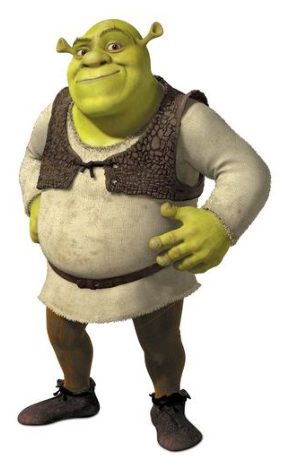

In [ ]:
image = read_image(IMAGE_NAME)
height, width = image.shape[:2]

show_image(image)

Картинка в памяти хранится как трехмерный массив `[h; w; 3]`, однако алгоритмы кластеризации требуют от нас двумерный массив `[n_samples; n_features]`. В случае картинок, `n_features` — 3, RGB код цвета каждого пикселя, а `n_samples` общее число пикселей.

Реализуйте функцию `preprocess_image`, которая получает картинку и возвращает нужный двумерный массив.

In [ ]:
def preprocess_image(image: np.ndarray) -> np.ndarray:
    """Функция для препроцессинга картинки

    Parameters
    ----------
    image: исходная картинка
        массив размером [h; w; 3]

    Return
    ------
        матрица размером [n_pixels; 3]
    """
    colurs_count = 3
    h = image.shape[0]
    w = image.shape[1]
    return np.reshape(image, newshape=(h * w, colurs_count))

In [ ]:
arr = np.array([[1,2,3],[4,5,6]])
np.reshape(arr, 6)

array([1, 2, 3, 4, 5, 6])

In [ ]:
X_train = preprocess_image(image)

assert X_train.shape == (height * width, 3)

In [ ]:
X_train

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       ...,
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

В качестве первого алгоритма возьмем [`KMeans`](https://scikit-learn.org/stable/modules/clustering.html#k-means). Его идея близка к алгоритму классификации "K ближайших соседей", считаются попарные расстояния между точками и наиболее близкие объединяются в кластеры

In [ ]:
k_means = KMeans(n_clusters=20, n_init=1, random_state=RANDOM_SEED)
k_means.fit(X_train)

KMeans(n_clusters=20, n_init=1, random_state=12648430)

Заменим каждый цвет на картинке на средний цвет кластера, куда попал соответствующий кластер.

Для этого реализуйте функцию `replace_to_centroid`, которая принимает полученные индексы кластеров и цвета кластеров и возвращает цвета для каждой точки.

In [ ]:
def replace_to_centroid(
    predicted_cluster: np.ndarray, centroids: np.ndarray
) -> np.ndarray:
    """Функция для получения центроиды кластера по ее индексу

    Parameters
    ----------
    predicted_cluster: предсказанные кластеры
        массив размером [n_samples]
        каждое значение от 0 до n_clusters
    centroids: центры кластеров
        массив размером [n_clusters; 3]

    Return
    ------
        матрица размером [n_samples; 3]
    """
    colurs_count = 3
    points_count = predicted_cluster.shape[0]
    matrix_of_colors = np.zeros(shape=(points_count, colurs_count))
    for i in range(points_count):
        matrix_of_colors[i] = centroids[predicted_cluster[i]]
    return matrix_of_colors


In [ ]:
np.unique(k_means.predict(X_train))

array([0, 1, 2, 3, 4], dtype=int32)

In [ ]:
predicted_clusters = k_means.predict(X_train)
X_predicted = replace_to_centroid(predicted_clusters, k_means.cluster_centers_)

assert X_predicted.shape == X_train.shape

Приведем матрицу обратно к формату картинки и посмотрим, что получилось!

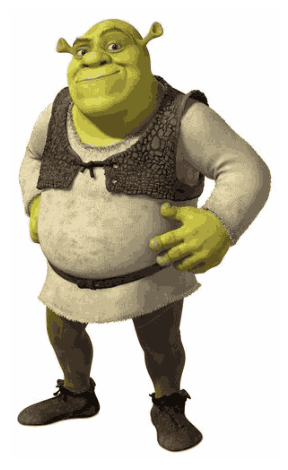

In [ ]:
new_image = X_predicted.reshape(height, width, 3).astype(np.int32)
show_image(new_image)

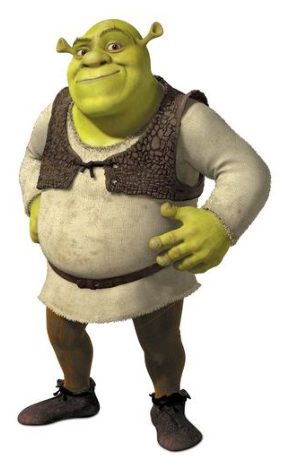

In [ ]:
image = read_image(IMAGE_NAME)
height, width = image.shape[:2]

show_image(image)

Изучите другие алгоритмы кластеризации, доступные в `sklearn`: [алгоритмы](https://scikit-learn.org/stable/modules/clustering.html).

Для применения к нашей задаче, необходимо выбрать такой, где задается число кластеров, обычно параметр называется `n_clusters`. Помните, что задача кластеризации трудная с вычислительной точки зрения, домашний ПК не всегда может с ней справиться.

Поэкспериментируйте с другими алгоритмами и сравните, как они ведут себя относительно `KMeans` для задачи сжатия изображений.